# Import Libraries

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from IPython.display import display


# Utility Functions

In [2]:
def show_images(imgs, titles=None, cmap="gray"):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))
    if titles is None:
        titles = [""] * n
    for i in range(n):
        axs[i].imshow(imgs[i], cmap=cmap)
        axs[i].set_title(titles[i])
        axs[i].axis("off")
    plt.show()

def compute_metrics(original, halftoned):
    arr_orig = np.asarray(original.convert("L"))
    arr_halftone = np.asarray(halftoned.convert("L"))
    psnr_val = psnr(arr_orig, arr_halftone)
    ssim_val = ssim(arr_orig, arr_halftone)
    return psnr_val, ssim_val

# Halftoning Functions

# Global Thresholding

In [3]:
def global_threshold(img, threshold=128):
    arr = np.asarray(img.convert("L"))
    out = (arr > threshold).astype(np.uint8) * 255
    return Image.fromarray(out, mode="L")

# Ordered Dithering (Bayer)

In [4]:
def bayer_matrix(n):
    if n == 1:
        return np.array([[0]])
    half = bayer_matrix(n//2)
    top = np.block([[4*half + 0, 4*half + 2],
                    [4*half + 3, 4*half + 1]])
    return top

def ordered_dither(img, matrix_size=8):
    arr = np.asarray(img.convert("L"))
    M = bayer_matrix(matrix_size)
    n = M.shape[0]
    thresh = (M + 0.5) * (255.0 / (n*n))
    H, W = arr.shape
    tiled = np.tile(thresh, (H//n + 1, W//n + 1))[:H, :W]
    out = (arr > tiled).astype(np.uint8) * 255
    return Image.fromarray(out, mode="L")


# Error Diffusion

In [5]:
def error_diffusion(img, kernel, threshold=128, serpentine=True):
    arr = np.asarray(img.convert("L")).astype(np.float32)
    H, W = arr.shape
    out = np.zeros_like(arr, dtype=np.uint8)
    kH, kW = kernel.shape
    center = (0, kW//2)

    for y in range(H):
        if serpentine and (y % 2 == 1):
            x_range = range(W-1, -1, -1)
            flip = True
        else:
            x_range = range(W)
            flip = False

        for x in x_range:
            old = arr[y, x]
            new = 255 if old >= threshold else 0
            out[y, x] = new
            err = old - new

            for ky in range(kH):
                for kx in range(kW):
                    weight = kernel[ky, kx]
                    if weight == 0:
                        continue
                    dx = center[1] - kx if flip else kx - center[1]
                    dy = ky - center[0]
                    nx, ny = x + dx, y + dy
                    if 0 <= ny < H and 0 <= nx < W:
                        arr[ny, nx] += err * weight
    return Image.fromarray(out, mode="L")


# Load Image

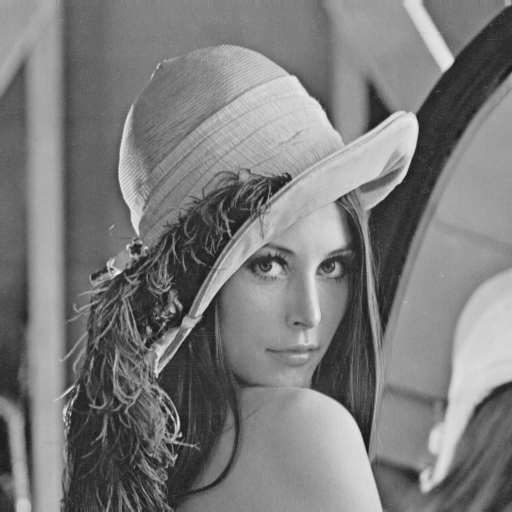

Original grayscale image loaded.


In [7]:
img_path = "C:/Users/anass/OneDrive/Desktop/Lenna_(test_image).png"  # Replace with your image path
img = Image.open(img_path).convert("RGB")
gray_img = img.convert("L")
display(gray_img)
print("Original grayscale image loaded.")

# Global Thresholding Experiments

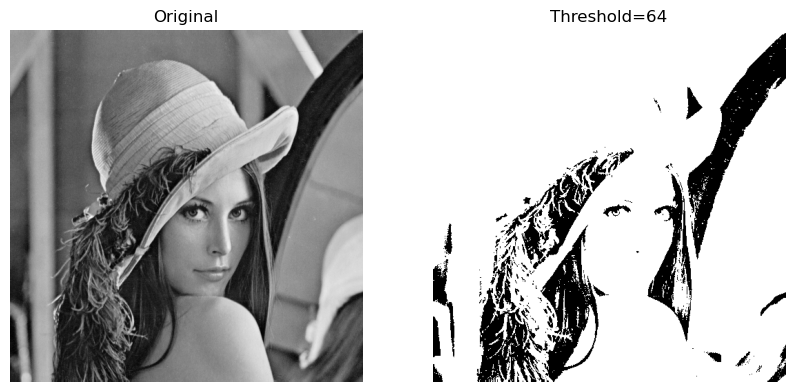

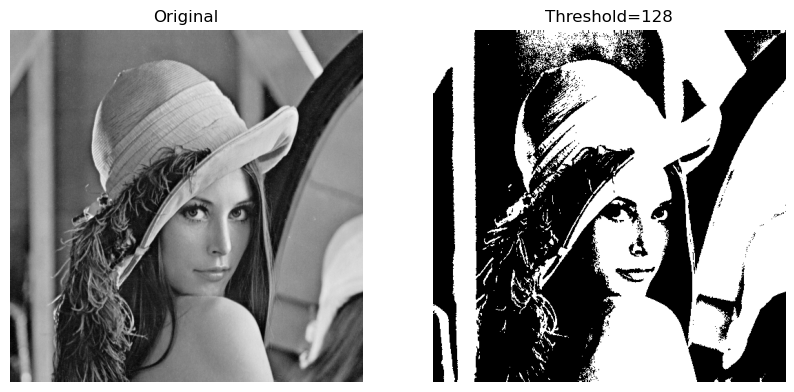

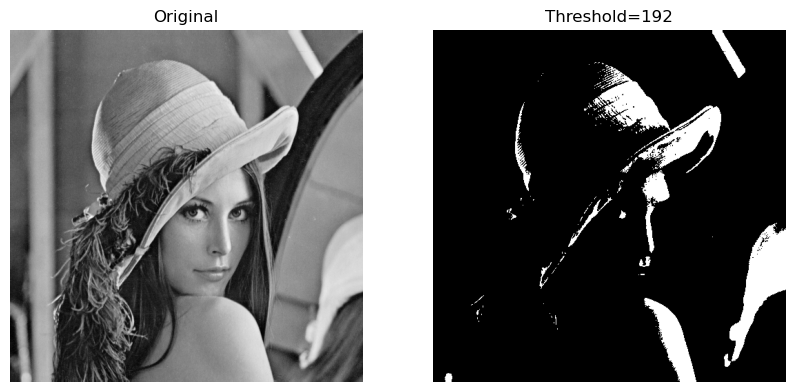

Threshold | PSNR | SSIM
       64 | 7.04 | 0.446
      128 | 8.85 | 0.318
      192 | 6.65 | 0.059


In [8]:
threshold_values = [64, 128, 192]
global_results = []

for t in threshold_values:
    halftoned = global_threshold(gray_img, t)
    psnr_val, ssim_val = compute_metrics(gray_img, halftoned)
    global_results.append((t, psnr_val, ssim_val))
    show_images([gray_img, halftoned], titles=[f"Original", f"Threshold={t}"])

print("Threshold | PSNR | SSIM")
for t, p, s in global_results:
    print(f"{t:>9} | {p:>4.2f} | {s:>4.3f}")

# Ordered Dithering Experiments

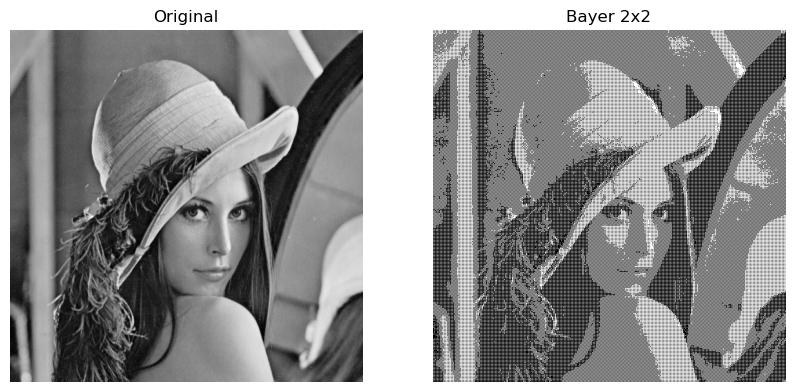

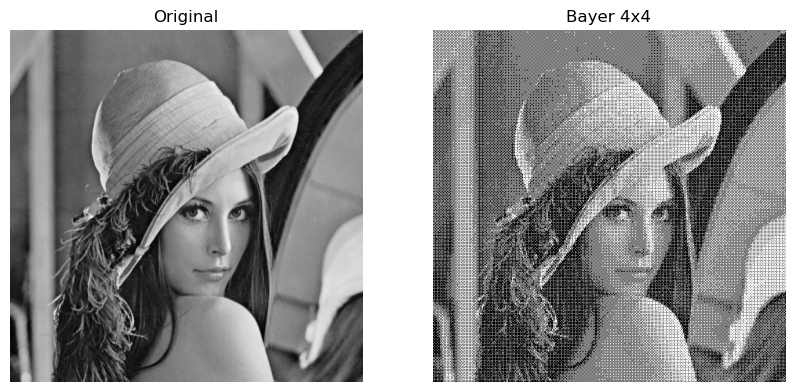

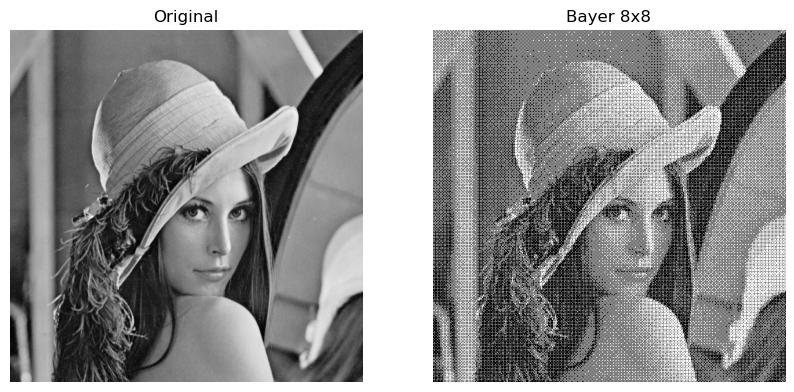

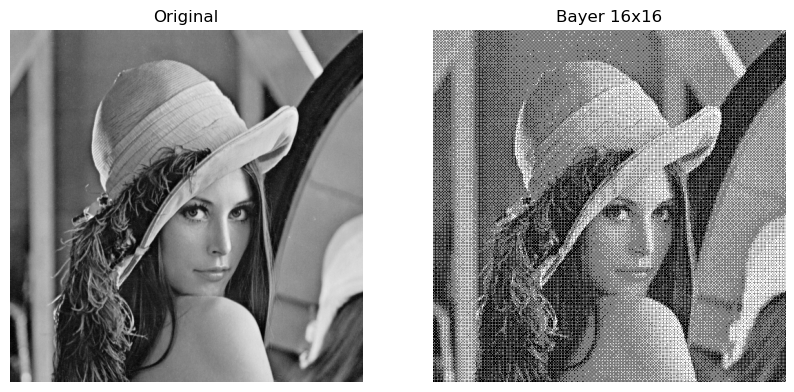

Matrix Size | PSNR | SSIM
          2 | 6.52 | 0.031
          4 | 6.68 | 0.036
          8 | 6.68 | 0.036
         16 | 6.69 | 0.036


In [9]:
matrix_sizes = [2, 4, 8, 16]
bayer_results = []

for size in matrix_sizes:
    halftoned = ordered_dither(gray_img, size)
    psnr_val, ssim_val = compute_metrics(gray_img, halftoned)
    bayer_results.append((size, psnr_val, ssim_val))
    show_images([gray_img, halftoned], titles=[f"Original", f"Bayer {size}x{size}"])

print("Matrix Size | PSNR | SSIM")
for sz, p, s in bayer_results:
    print(f"{sz:>11} | {p:>4.2f} | {s:>4.3f}")

# Error Diffusion Experiments

In [10]:
FLOYD_STEINBERG = np.array([[0,0,7],[3,5,1]]) / 16.0
JARVIS = np.array([[0,0,0,7,5],[3,5,7,5,3],[1,3,5,3,1]]) / 48.0
STUCKI = np.array([[0,0,0,8,4],[2,4,8,4,2],[1,2,4,2,1]]) / 42.0
SIERRA = np.array([[0,0,0,5,3],[2,4,5,4,2],[0,2,3,2,0]]) / 32.0
ATKINSON = np.array([[0,0,1,1,0],[0,1,1,0,0],[0,0,1,0,0]]) / 8.0

In [11]:
kernels = {
    "Floyd–Steinberg": FLOYD_STEINBERG,
    "Jarvis": JARVIS,
    "Stucki": STUCKI,
    "Sierra": SIERRA,
    "Atkinson": ATKINSON
}

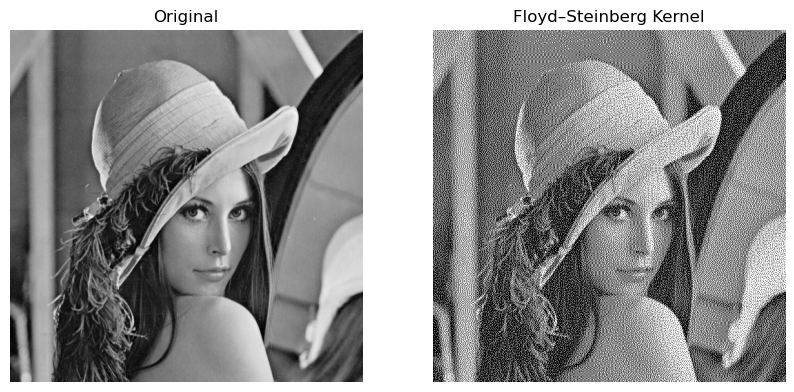

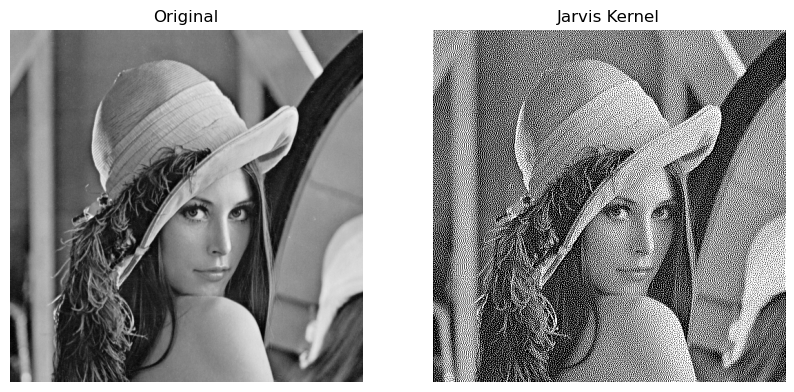

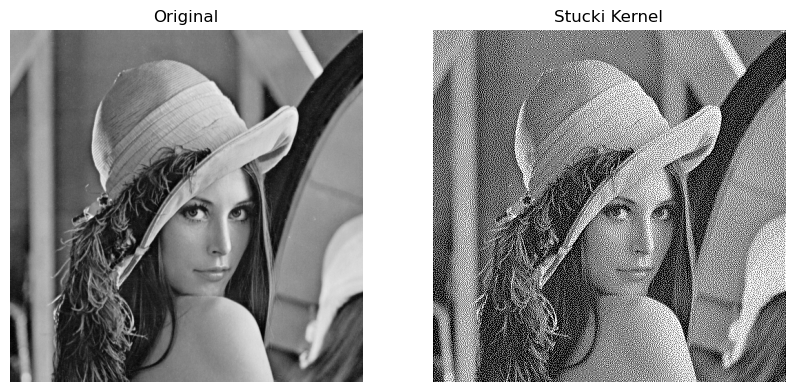

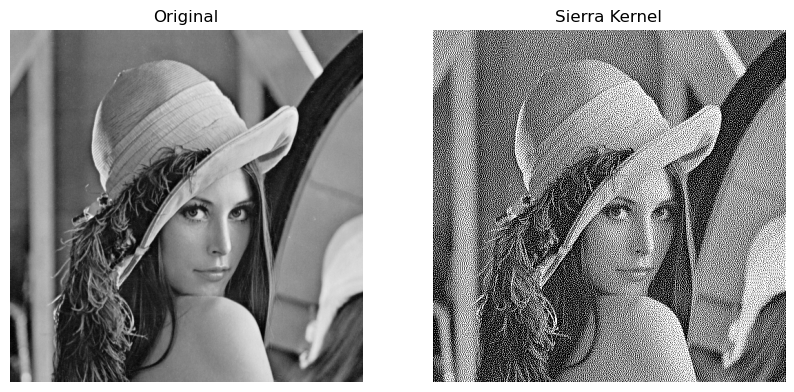

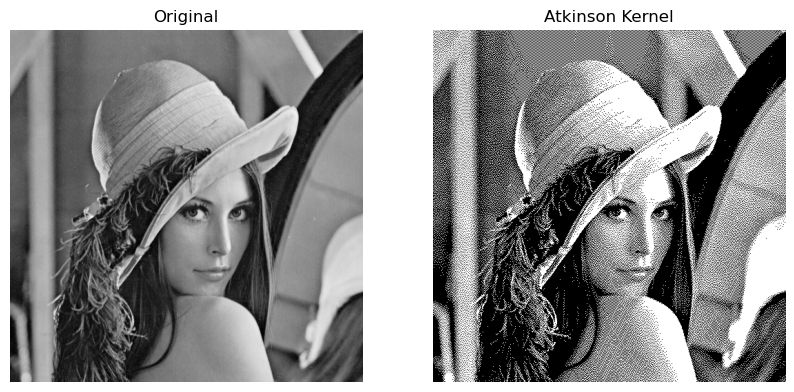

Kernel Type       | PSNR | SSIM
Floyd–Steinberg | 6.70 | 0.039
         Jarvis | 6.76 | 0.051
         Stucki | 6.74 | 0.047
         Sierra | 6.75 | 0.049
       Atkinson | 7.71 | 0.120


In [12]:
error_results = []

for name, kernel in kernels.items():
    halftoned = error_diffusion(gray_img, kernel)
    psnr_val, ssim_val = compute_metrics(gray_img, halftoned)
    error_results.append((name, psnr_val, ssim_val))
    show_images([gray_img, halftoned], titles=[f"Original", f"{name} Kernel"])

print("Kernel Type       | PSNR | SSIM")
for n, p, s in error_results:
    print(f"{n:>15} | {p:>4.2f} | {s:>4.3f}")


# Plots

## Global Threshold Plots

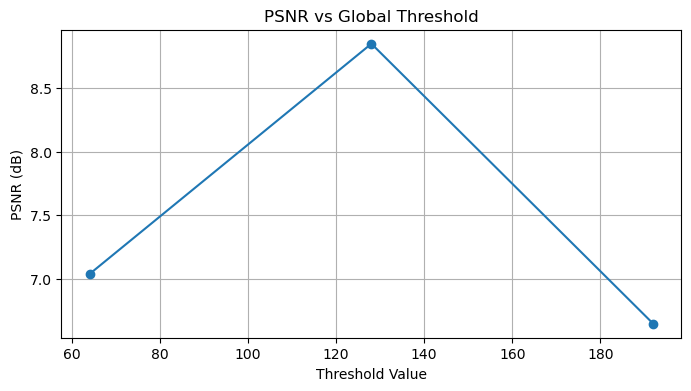

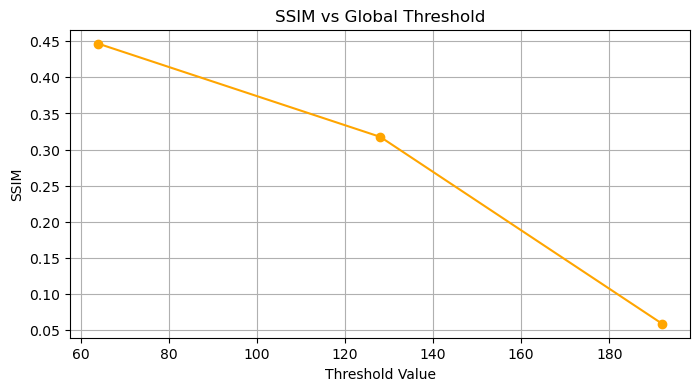

In [13]:
plt.figure(figsize=(8,4))
plt.plot([t for t,_,_ in global_results], [p for _,p,_ in global_results], marker='o')
plt.title("PSNR vs Global Threshold")
plt.xlabel("Threshold Value")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot([t for t,_,_ in global_results], [s for _,_,s in global_results], marker='o', color='orange')
plt.title("SSIM vs Global Threshold")
plt.xlabel("Threshold Value")
plt.ylabel("SSIM")
plt.grid(True)
plt.show()

## Ordered Dithering Plots

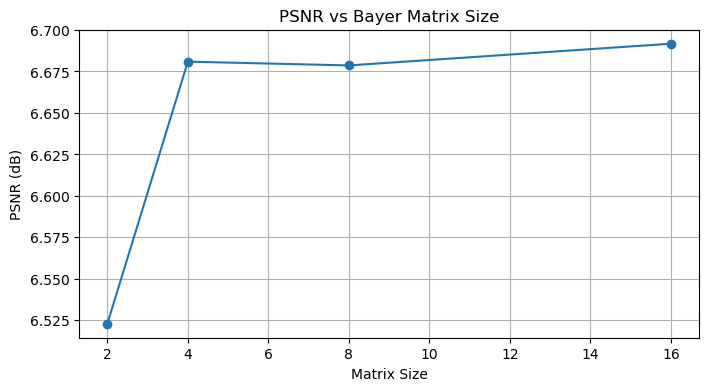

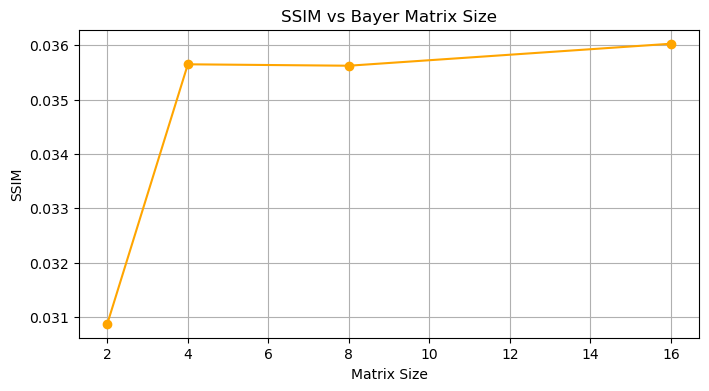

In [14]:
plt.figure(figsize=(8,4))
plt.plot([sz for sz,_,_ in bayer_results], [p for _,p,_ in bayer_results], marker='o')
plt.title("PSNR vs Bayer Matrix Size")
plt.xlabel("Matrix Size")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot([sz for sz,_,_ in bayer_results], [s for _,_,s in bayer_results], marker='o', color='orange')
plt.title("SSIM vs Bayer Matrix Size")
plt.xlabel("Matrix Size")
plt.ylabel("SSIM")
plt.grid(True)
plt.show()

## Error Diffusion Bar Plots

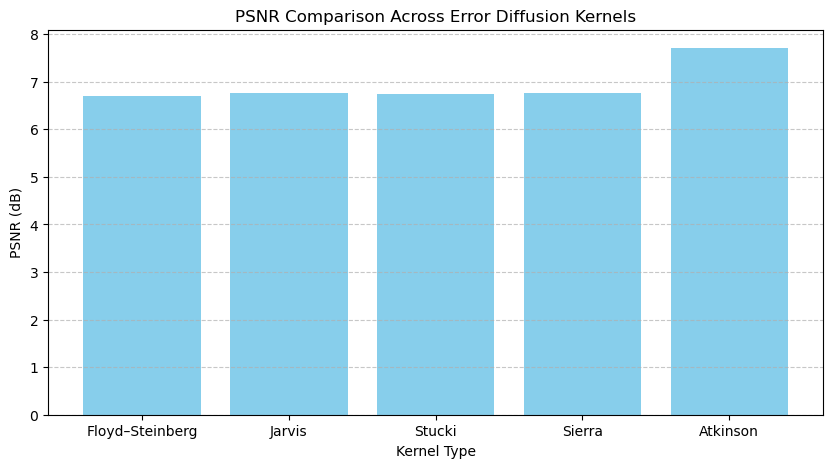

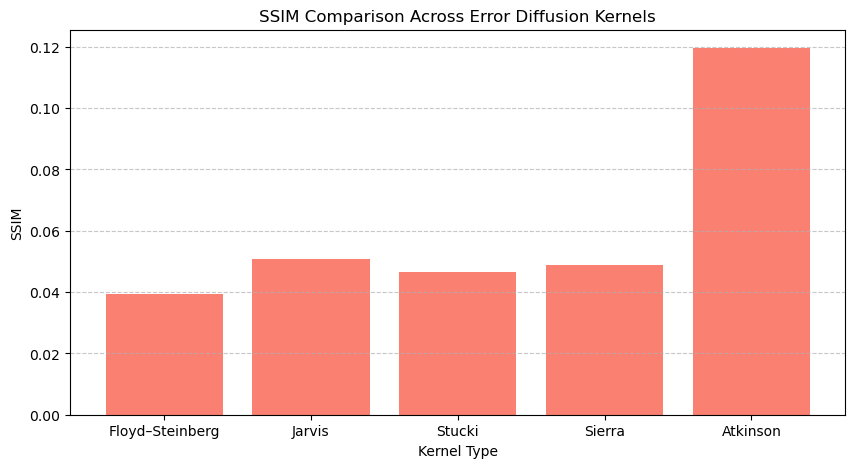

In [15]:
kernel_names = [name for name, _, _ in error_results]
psnr_values = [p for _, p, _ in error_results]
ssim_values = [s for _, _, s in error_results]

plt.figure(figsize=(10,5))
plt.bar(kernel_names, psnr_values, color='skyblue')
plt.title("PSNR Comparison Across Error Diffusion Kernels")
plt.ylabel("PSNR (dB)")
plt.xlabel("Kernel Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10,5))
plt.bar(kernel_names, ssim_values, color='salmon')
plt.title("SSIM Comparison Across Error Diffusion Kernels")
plt.ylabel("SSIM")
plt.xlabel("Kernel Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


📘 Quantitative Evaluation of Halftoning Methods



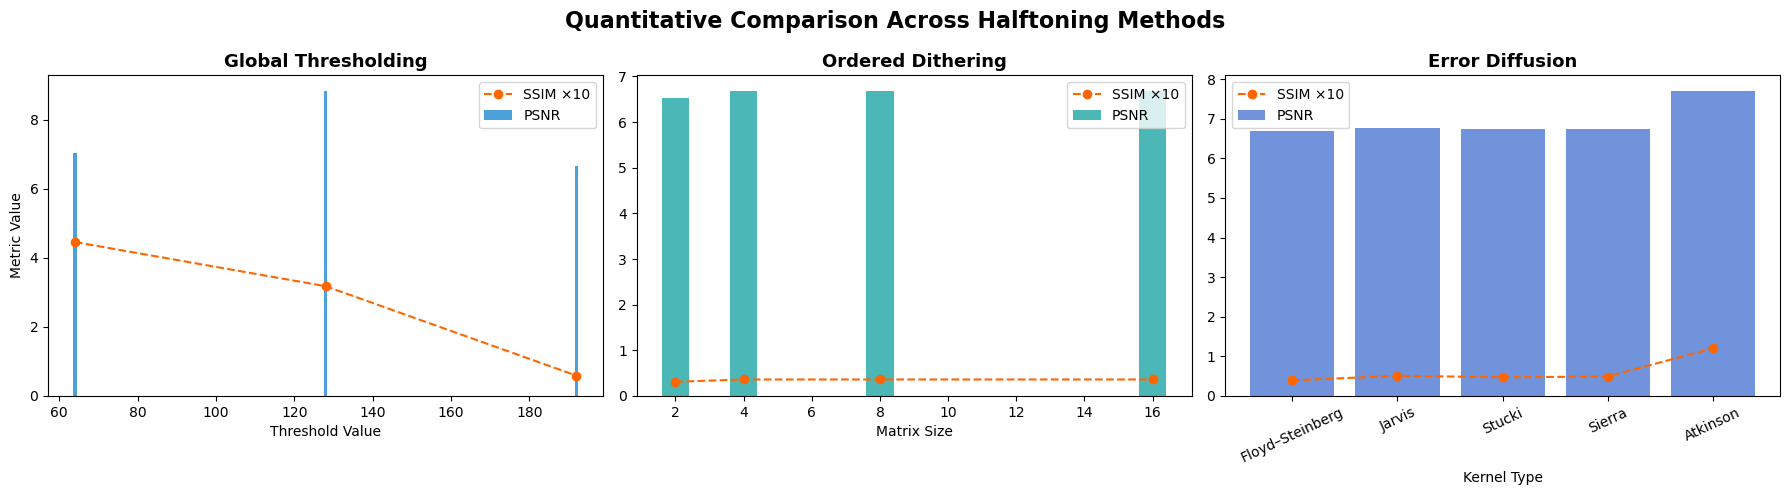

In [16]:
# ============================================
# 📊 Professional Quantitative Result Tables
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# --- Data ---
data_threshold = {
    "Threshold": [64, 128, 192],
    "PSNR": [7.04, 8.85, 6.65],
    "SSIM": [0.446, 0.318, 0.059]
}

data_ordered = {
    "Matrix Size": [2, 4, 8, 16],
    "PSNR": [6.52, 6.68, 6.68, 6.69],
    "SSIM": [0.031, 0.036, 0.036, 0.036]
}

data_error = {
    "Kernel Type": ["Floyd–Steinberg", "Jarvis", "Stucki", "Sierra", "Atkinson"],
    "PSNR": [6.70, 6.76, 6.74, 6.75, 7.71],
    "SSIM": [0.039, 0.051, 0.047, 0.049, 0.120]
}

df_threshold = pd.DataFrame(data_threshold)
df_ordered = pd.DataFrame(data_ordered)
df_error = pd.DataFrame(data_error)

# --- Style Functions ---
def style_table(df, title, highlight_col=None):
    styled = (
        df.style
        .set_caption(f"<b style='font-size:18px;'>{title}</b>")
        .format(precision=3)
        .set_table_styles([
            {'selector': 'caption', 'props': 'caption-side: top; text-align: center; font-weight: bold; color: #004080;'},
            {'selector': 'th', 'props': 'background-color: #004080; color: white; font-size:14px; text-align: center;'},
            {'selector': 'td', 'props': 'text-align: center; font-size:13px;'}
        ])
        .background_gradient(cmap=cm.Blues, subset=highlight_col)
        .hide(axis="index")
    )
    return styled

# --- Display Tables ---
print("\n📘 Quantitative Evaluation of Halftoning Methods\n")

display(style_table(df_threshold, "Global Thresholding Results", highlight_col=["PSNR", "SSIM"]))
display(style_table(df_ordered, "Ordered Dithering Results", highlight_col=["PSNR", "SSIM"]))
display(style_table(df_error, "Error Diffusion Results", highlight_col=["PSNR", "SSIM"]))

# --- Bar Chart Comparison ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Quantitative Comparison Across Halftoning Methods", fontsize=16, fontweight='bold')

# Global Thresholding
axs[0].bar(df_threshold["Threshold"], df_threshold["PSNR"], color="#007acc", alpha=0.7, label="PSNR")
axs[0].plot(df_threshold["Threshold"], df_threshold["SSIM"]*10, "o--", color="#ff6600", label="SSIM ×10")
axs[0].set_title("Global Thresholding", fontsize=13, weight="bold")
axs[0].set_xlabel("Threshold Value")
axs[0].set_ylabel("Metric Value")
axs[0].legend()

# Ordered Dithering
axs[1].bar(df_ordered["Matrix Size"], df_ordered["PSNR"], color="#009999", alpha=0.7, label="PSNR")
axs[1].plot(df_ordered["Matrix Size"], df_ordered["SSIM"]*10, "o--", color="#ff6600", label="SSIM ×10")
axs[1].set_title("Ordered Dithering", fontsize=13, weight="bold")
axs[1].set_xlabel("Matrix Size")
axs[1].legend()

# Error Diffusion
axs[2].bar(df_error["Kernel Type"], df_error["PSNR"], color="#3366cc", alpha=0.7, label="PSNR")
axs[2].plot(df_error["Kernel Type"], df_error["SSIM"]*10, "o--", color="#ff6600", label="SSIM ×10")
axs[2].set_title("Error Diffusion", fontsize=13, weight="bold")
axs[2].set_xlabel("Kernel Type")
axs[2].tick_params(axis='x', rotation=25)
axs[2].legend()

plt.tight_layout()
plt.show()
